# Heartbeat Anomaly Detection

![GIF](https://cainvas-static.s3.amazonaws.com/media/user_data/arya.ashish/heart.gif)

#### According to WHO 17.9 million people die each year due to Cardiovascular Diseases.Over the years it has been found that these deaths can be prevented if the diseases are diagnosed in early stages.AI has brought a major development in the field of healthcare for early diagnosis of these diseases.

#### This model if coupled with digital stethoscopes or some similar IoT Device can help in the detection of anomalies in the Heartbeat Sounds of an individual.

# Importing the Dataset

In [ ]:
!wget -N "https://cainvas-static.s3.amazonaws.com/media/user_data/arya.ashish/heart.zip"
!unzip -o heart.zip 
!rm heart.zip

# Importing Necessary Libraries

In [2]:
# Pandas
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

# Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical
from keras.optimizers import Adam

# Audio
import librosa
import librosa.display

# Plot
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

# Utility
import os
import glob
import numpy as np
from tqdm import tqdm
import itertools

# To ignore any warnings
import warnings                       
warnings.filterwarnings("ignore")


# gather software versions
import tensorflow as tf; print('tensorflow version: ', tf.__version__)
import keras; print('keras version: ',keras.__version__)

# If any warning pops up run the cell again.There is nothing to worry about.

Populating the interactive namespace from numpy and matplotlib
tensorflow version:  2.3.1
keras version:  2.4.3


### Build Dataset

In [3]:
dataset = []
for folder in ["heart/set_a/**"]:
    for filename in glob.iglob(folder):
        if os.path.exists(filename):
            label = os.path.basename(filename).split("_")[0]
            # skip audio smaller than 4 secs
            if librosa.get_duration(filename=filename)>=4:
                if label not in ["Aunlabelledtest"]:
                    dataset.append({
                        "filename": filename,
                        "label": label
                    })
dataset = pd.DataFrame(dataset)

# Exploratory Data Analysis

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  93 non-null     object
 1   label     93 non-null     object
dtypes: object(2)
memory usage: 1.6+ KB


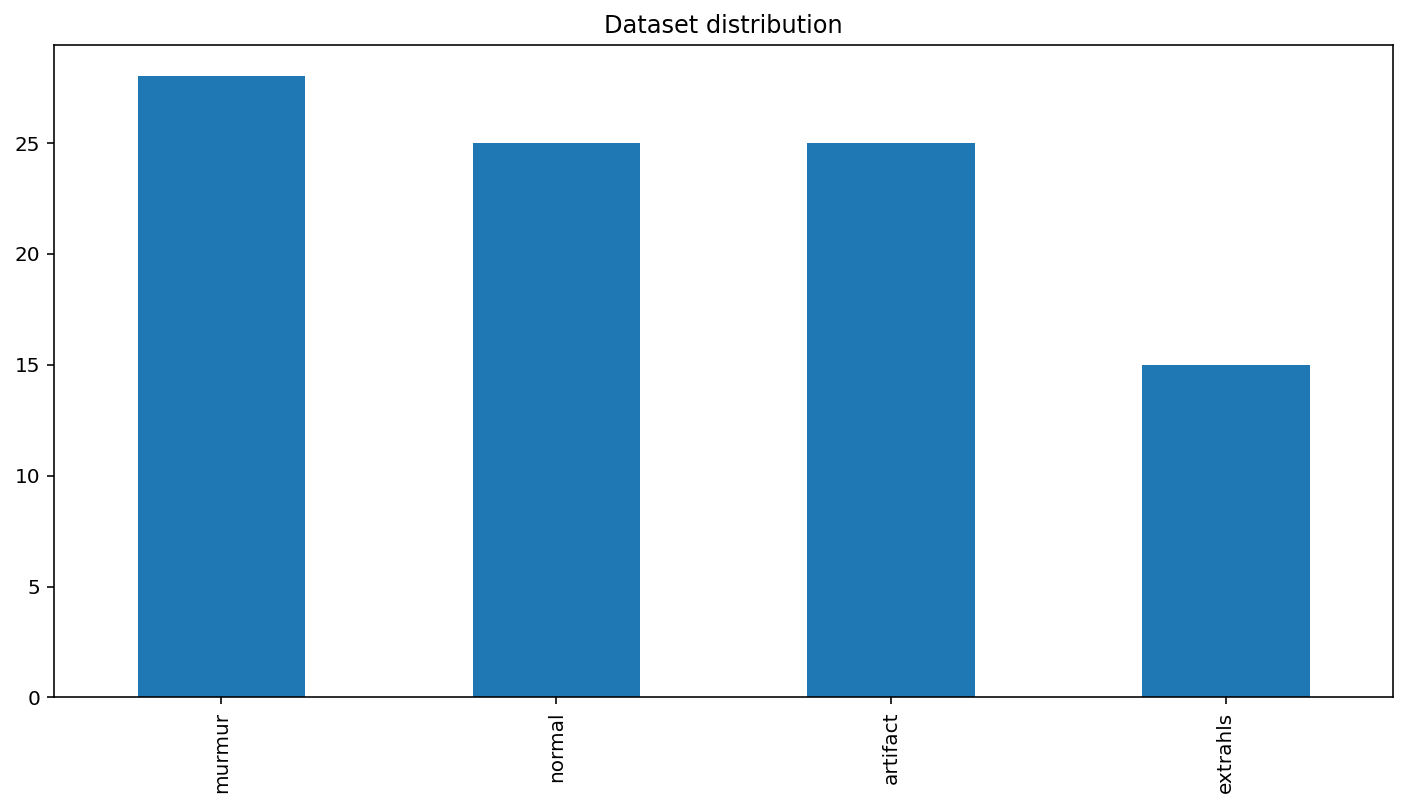

In [5]:
plt.figure(figsize=(12,6))
dataset.label.value_counts().plot(kind='bar', title="Dataset distribution")
plt.show()

In [6]:
# parent folder of sound files
INPUT_DIR="heart"
# 16 KHz
SAMPLE_RATE = 16000
# seconds
MAX_SOUND_CLIP_DURATION=12 

In [7]:
set_a=pd.read_csv(INPUT_DIR+"/set_a.csv")
set_a.head()
set_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   dataset   176 non-null    object 
 1   fname     176 non-null    object 
 2   label     124 non-null    object 
 3   sublabel  0 non-null      float64
dtypes: float64(1), object(3)
memory usage: 5.6+ KB


In [8]:
train_ab=set_a
train_ab.describe()

sublabel
count       0.0
mean        NaN
std         NaN
min         NaN
25%         NaN
50%         NaN
75%         NaN
max         NaN

In [9]:
#get all unique labels
nb_classes=train_ab.label.unique()

print("Number of training examples=", train_ab.shape[0], "  Number of classes=", len(train_ab.label.unique()))
print (nb_classes)

Number of training examples= 176   Number of classes= 5
['artifact' 'extrahls' 'murmur' 'normal' nan]


In [10]:
print('Minimum samples per category = ', min(train_ab.label.value_counts()))
print('Maximum samples per category = ', max(train_ab.label.value_counts()))

Minimum samples per category =  19
Maximum samples per category =  40


## Normal Case

In the Normal category there are normal, healthy heart sounds. A normal heart sound has a clear “lub dub, lub dub” pattern, with the time from “lub” to “dub” shorter than the time from “dub” to the next “lub”.

In [11]:
normal_file=INPUT_DIR+"/set_a/normal__201106111136.wav"

In [12]:
# hear it
import IPython.display as ipd
ipd.Audio(normal_file) 

In [13]:
# Load use wave 
import wave
wav = wave.open(normal_file)
print("Sampling (frame) rate = ", wav.getframerate())
print("Total samples (frames) = ", wav.getnframes())
print("Duration = ", wav.getnframes()/wav.getframerate())

Sampling (frame) rate =  44100
Total samples (frames) =  218903
Duration =  4.963786848072562


In [14]:
# Load using Librosa
y, sr = librosa.load(normal_file, duration=5)   #default sampling rate is 22 HZ
dur=librosa.get_duration(y)
print ("duration:", dur)
print(y.shape, sr)

duration: 4.963809523809524
(109452,) 22050


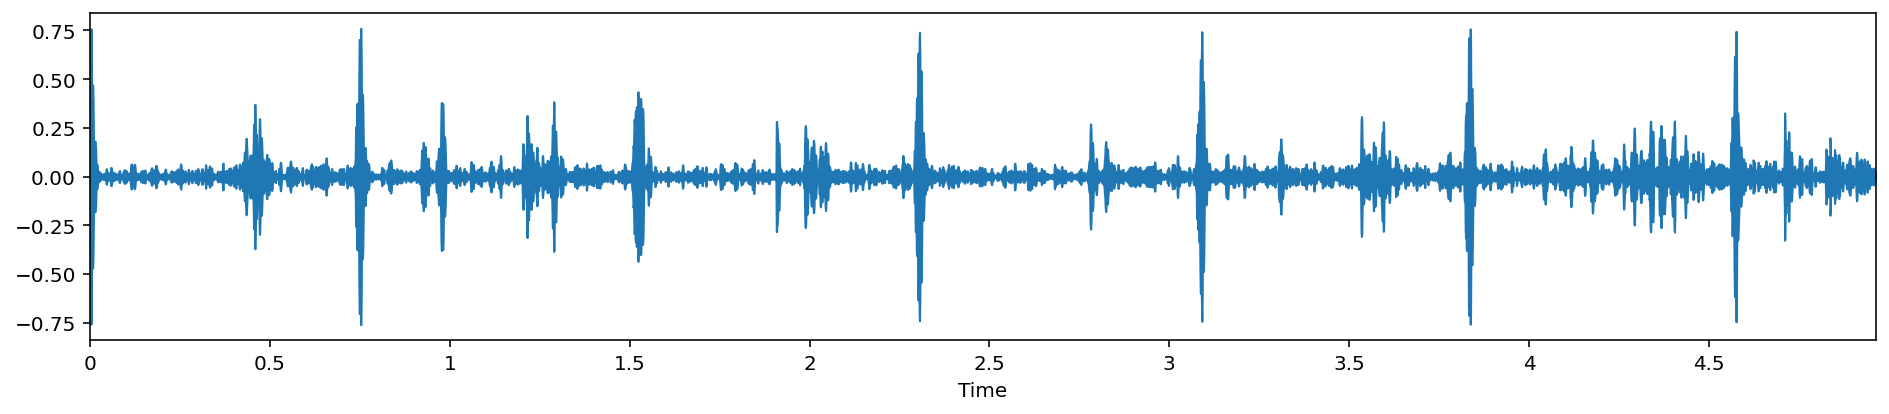

In [15]:
# librosa plot
plt.figure(figsize=(16, 3))
librosa.display.waveplot(y, sr=sr)

## Murmur Case

Heart murmurs sound as though there is a “whooshing, roaring, rumbling, or turbulent fluid” noise in one of two temporal locations: (1) between “lub” and “dub”, or (2) between “dub” and “lub”. They can be a symptom of many heart disorders, some serious. There will still be a “lub” and a “dub”.

In [16]:
# murmur case
murmur_file=INPUT_DIR+"/set_a/murmur__201108222231.wav"
y2, sr2 = librosa.load(murmur_file,duration=5)
dur=librosa.get_duration(y)
print ("duration:", dur)
print(y2.shape,sr2)

duration: 4.963809523809524
(110250,) 22050


In [17]:
# heart it
import IPython.display as ipd
ipd.Audio(murmur_file) 

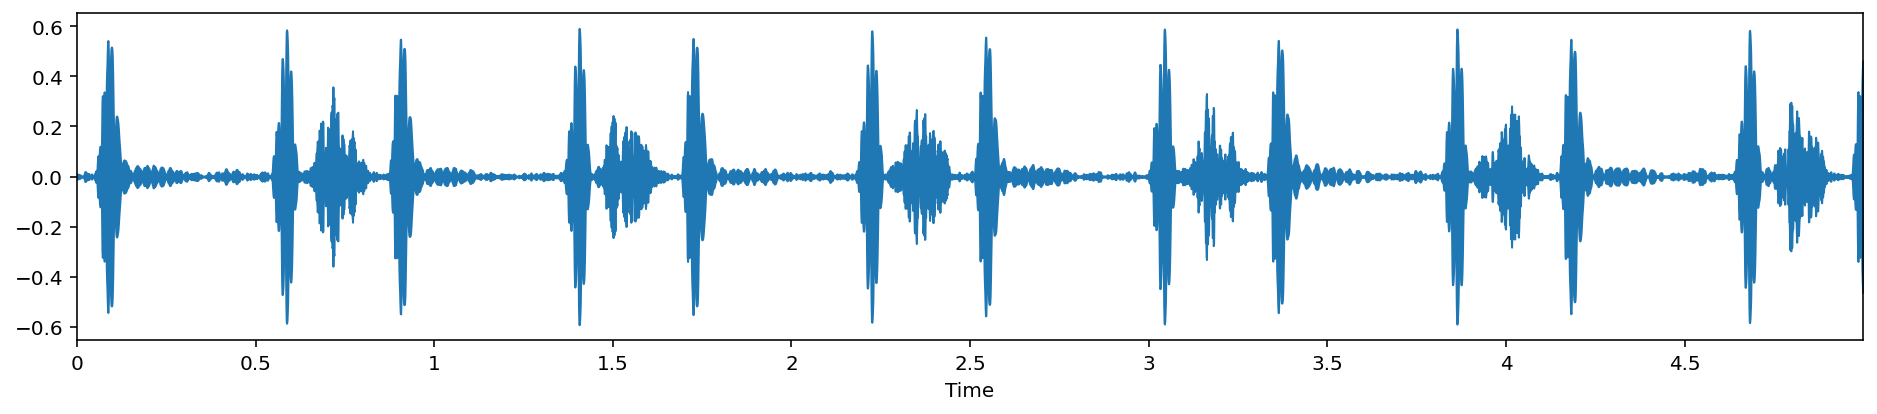

In [18]:
# show it
plt.figure(figsize=(16, 3))
librosa.display.waveplot(y2, sr=sr2)

## Artifact

In the Artifact category there are a wide range of different sounds, including feedback squeals and echoes, speech, music and noise. There are usually no discernable heart sounds, and thus little or no temporal periodicity at frequencies below 195 Hz.

In [19]:
# sample file
artifact_file=INPUT_DIR+"/set_a/artifact__201012172012.wav"
y4, sr4 = librosa.load(artifact_file, duration=5)
dur=librosa.get_duration(y)
print ("duration:", dur)
print(y4.shape,sr4)

duration: 4.963809523809524
(110250,) 22050


In [20]:
# heart it
import IPython.display as ipd
ipd.Audio(artifact_file) 

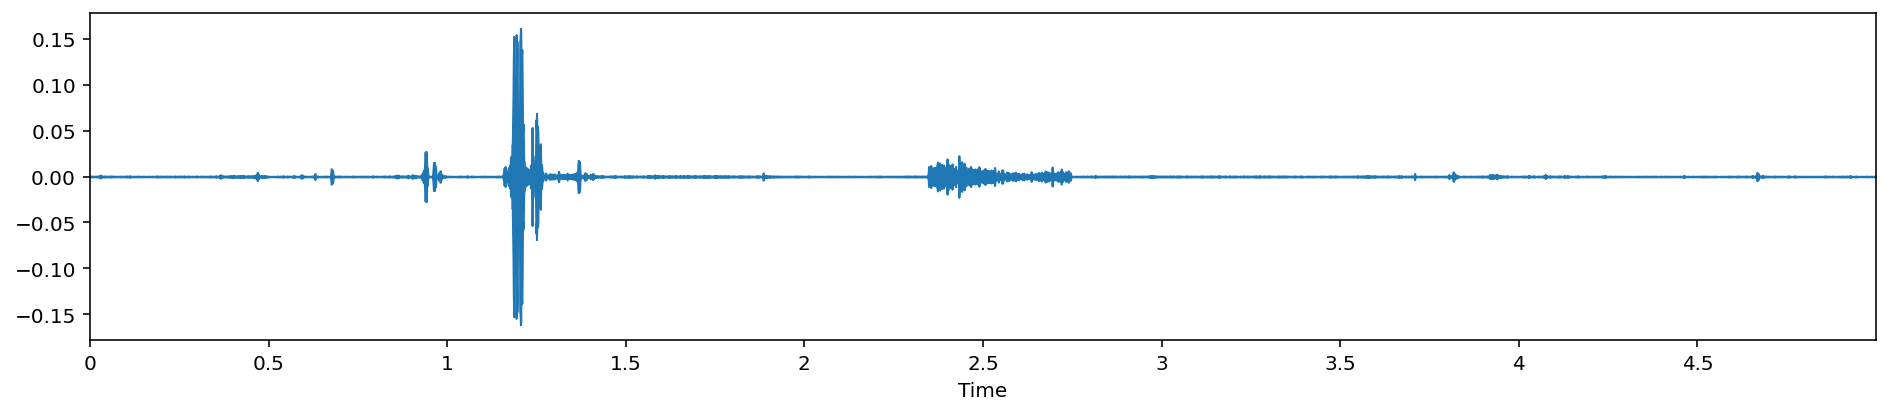

In [21]:
# show it
plt.figure(figsize=(16, 3))
librosa.display.waveplot(y4, sr=sr4)

## Extrahls

Extrahls sounds may appear occasionally and can be identified because there is a heart sound that is out of rhythm involving extra or skipped heartbeats, e.g. a “lub-lub dub” or a “lub dub-dub”.It can be sign of a disease. 

In [22]:
# sample file
extrahls_file=INPUT_DIR+"/set_a/extrahls__201101070953.wav"
y5, sr5 = librosa.load(extrahls_file, duration=5)
dur=librosa.get_duration(y)
print ("duration:", dur)
print(y5.shape,sr5)

duration: 4.963809523809524
(110250,) 22050


In [23]:
# heart it
import IPython.display as ipd
ipd.Audio(extrahls_file) 

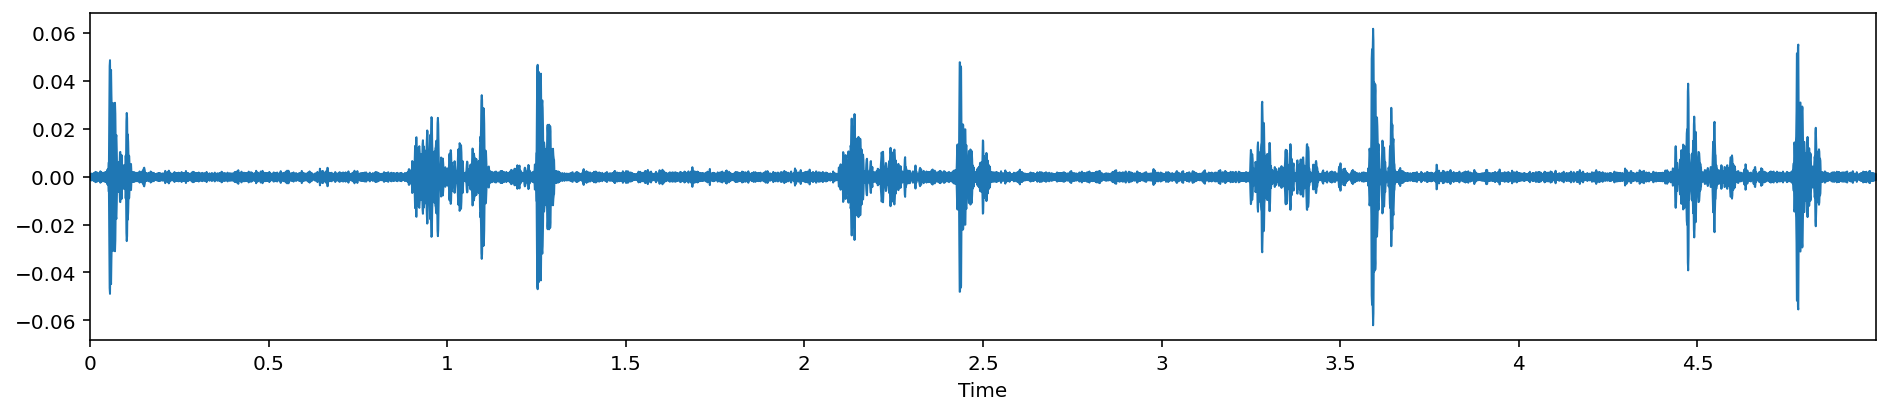

In [24]:
# show it
plt.figure(figsize=(16, 3))
librosa.display.waveplot(y5, sr=sr5)

### Split dataset in train and test

In [25]:
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

print("Train: %i" % len(train))
print("Test: %i" % len(test))

Train: 74
Test: 19


### Show Audio info

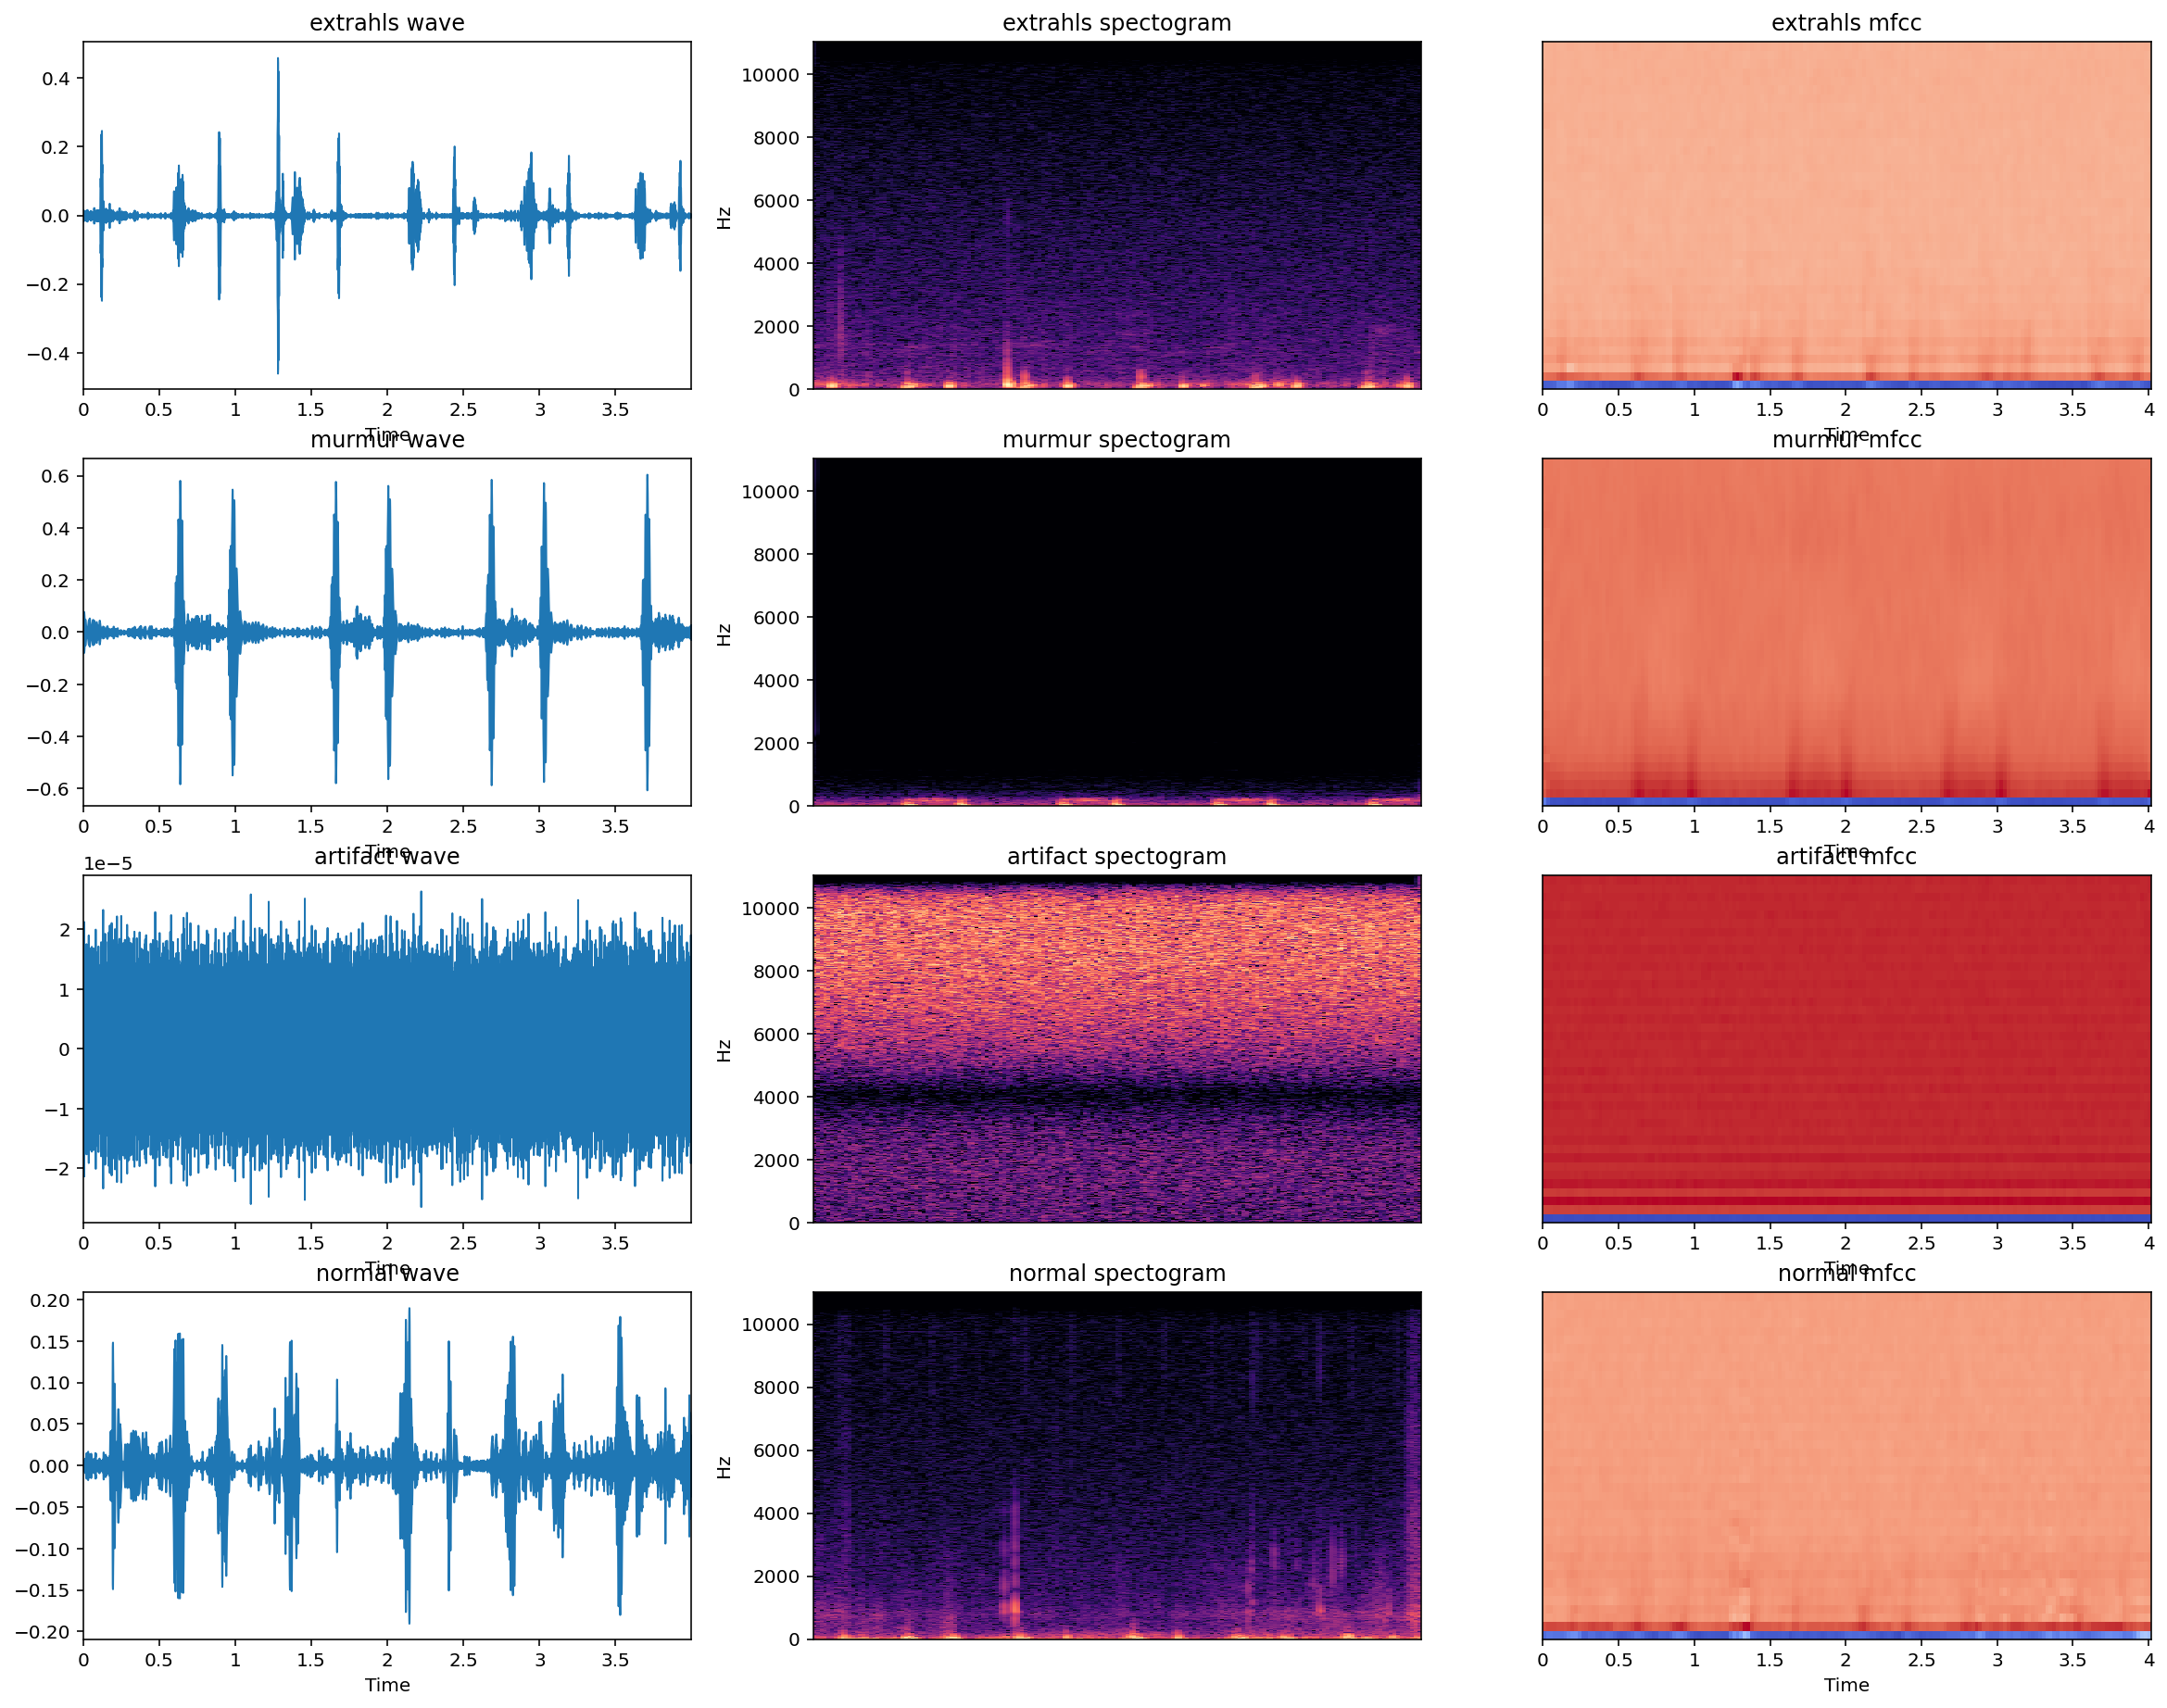

In [26]:
plt.figure(figsize=(20,20))
idx = 0
for label in dataset.label.unique():    
    y, sr = librosa.load(dataset[dataset.label==label].filename.iloc[0], duration=4)
    idx+=1
    plt.subplot(5, 3, idx)
    plt.title("%s wave" % label)
    librosa.display.waveplot(y, sr=sr)
    idx+=1
    plt.subplot(5, 3, idx)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, y_axis='linear')
    plt.title("%s spectogram" % label)
    idx+=1
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    plt.subplot(5, 3, idx)
    librosa.display.specshow(mfccs, x_axis='time')
    plt.title("%s mfcc" % label)
plt.show()


### Extract features from audio

In [27]:
def extract_features(audio_path):
    y, sr = librosa.load(audio_path, duration=4)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return mfccs

In [28]:
%%time
x_train, x_test = [], []
print("Extract features from TRAIN  and TEST dataset")
for idx in tqdm(range(len(train))):
    x_train.append(extract_features(train.filename.iloc[idx]))

for idx in tqdm(range(len(test))):
    x_test.append(extract_features(test.filename.iloc[idx]))
    
    
x_test = np.asarray(x_test)
x_train = np.asarray(x_train)

print("X train:", x_train.shape)
print("X test:", x_test.shape)

  1%|▏         | 1/74 [00:00<00:13,  5.38it/s]

Extract features from TRAIN  and TEST dataset


100%|██████████| 19/19 [00:03<00:00,  5.26it/s]

X train: (74, 40, 173)
X test: (19, 40, 173)
CPU times: user 23.4 s, sys: 27.9 s, total: 51.3 s
Wall time: 17.3 s


### Encode labels

In [29]:
encoder = LabelEncoder()
encoder.fit(train.label)

y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)

### Input shapes

In [30]:

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)



print("X train:", x_train.shape)
print("Y train:", y_train.shape)
print()
print("X test:", x_test.shape)
print("Y test:", y_test.shape)

X train: (74, 40, 173, 1)
Y train: (74, 4)

X test: (19, 40, 173, 1)
Y test: (19, 4)


### Build Model

In [31]:
# Model architecture
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(GlobalAveragePooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))

model.add(Dense(len(encoder.classes_), activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 39, 172, 16)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 86, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 86, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 85, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 42, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 42, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 41, 64)         8

### Compile model

In [32]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(lr = 0.001))

### Fit model

In [33]:
history = model.fit(x_train, y_train,
              batch_size=256,
              epochs=200,
              validation_data=(x_test, y_test),
              shuffle=True)

Epoch 1/200
1/1 [==============================] - 0s 215ms/step - loss: 7.9892 - accuracy: 0.2973 - val_loss: 5.1374 - val_accuracy: 0.1579
Epoch 2/200
1/1 [==============================] - 0s 27ms/step - loss: 11.0611 - accuracy: 0.2027 - val_loss: 2.5789 - val_accuracy: 0.6316
Epoch 3/200
1/1 [==============================] - 0s 27ms/step - loss: 14.0909 - accuracy: 0.3784 - val_loss: 2.2652 - val_accuracy: 0.3158
Epoch 4/200
1/1 [==============================] - 0s 27ms/step - loss: 14.8501 - accuracy: 0.2432 - val_loss: 1.8213 - val_accuracy: 0.6316
Epoch 5/200
1/1 [==============================] - 0s 29ms/step - loss: 9.9683 - accuracy: 0.3378 - val_loss: 1.9419 - val_accuracy: 0.5789
Epoch 6/200
1/1 [==============================] - 0s 27ms/step - loss: 7.1945 - accuracy: 0.4189 - val_loss: 1.6900 - val_accuracy: 0.5263
Epoch 7/200
1/1 [==============================] - 0s 28ms/step - loss: 3.8787 - accuracy: 0.3919 - val_loss: 1.4916 - val_accuracy: 0.6842
Epoch 8/200
1/1 

### Model performance can be increased by increasing number of epochs, training data and creating custom call-backs

## Training Plot

Text(0.5, 1.0, 'Accuracy Curves')

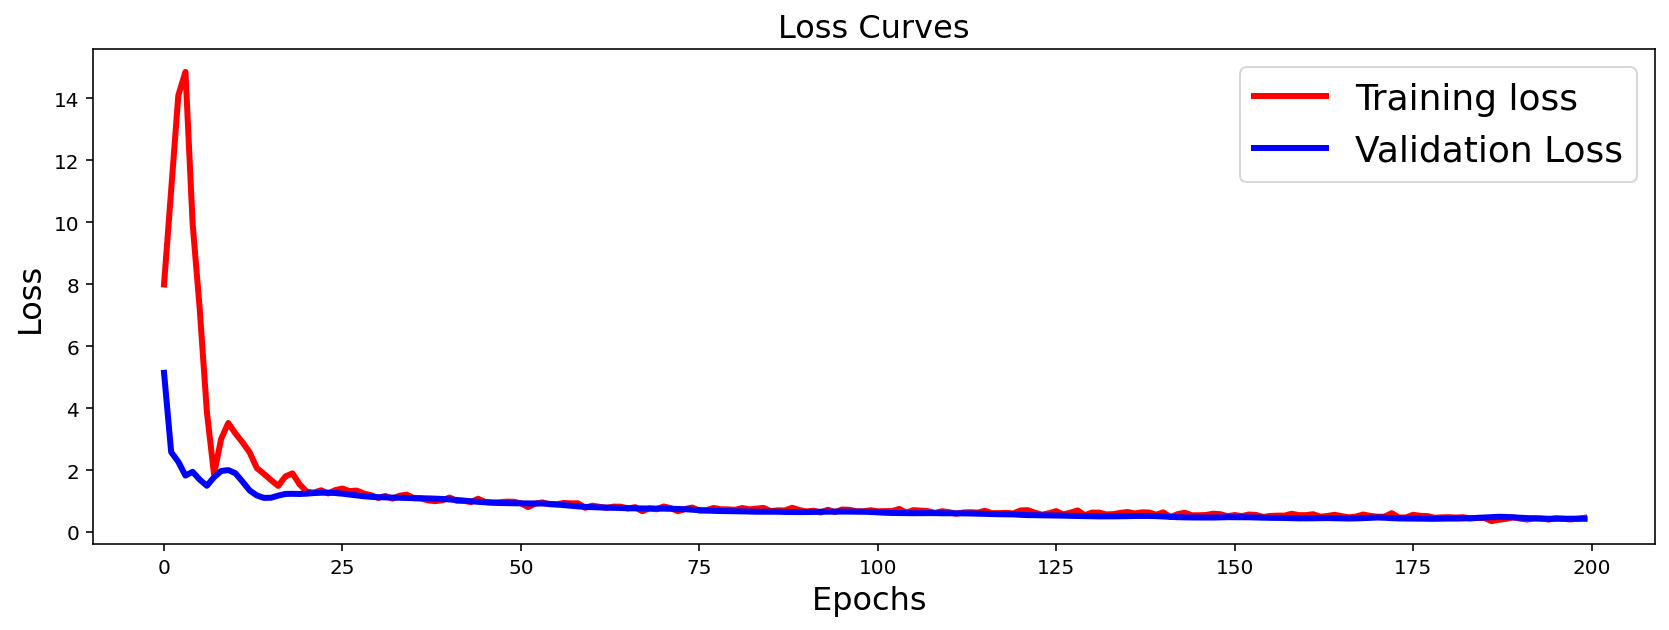

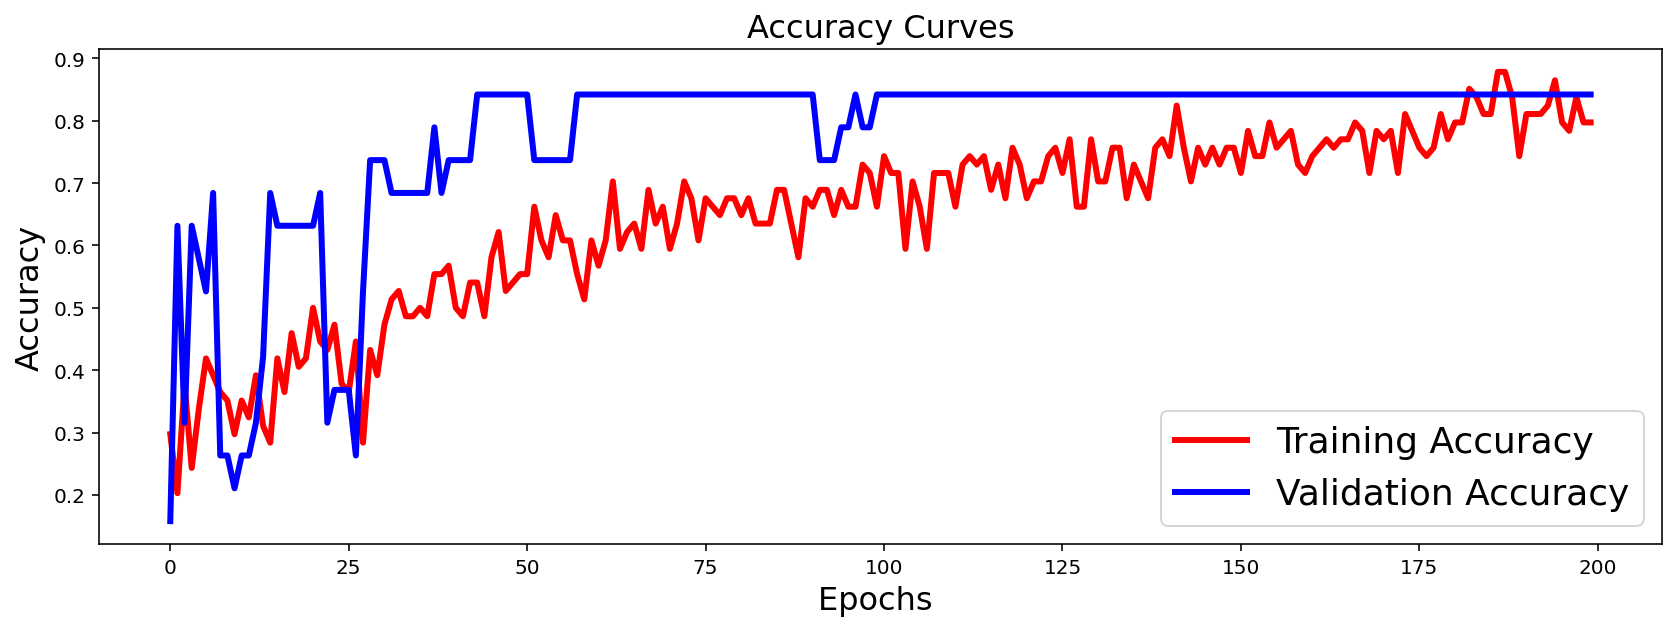

In [34]:
# Loss Curves
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

### Save model

In [35]:
# Save model and weights
model_name = "HAD.h5"
model.save(model_name)
print('Saved trained model at %s ' % model_name)

Saved trained model at HAD.h5 


### Evaluate model

In [36]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

1/1 [==============================] - 0s 2ms/step - loss: 0.4260 - accuracy: 0.8421
Test loss: 0.42598432302474976
Test accuracy: 0.8421052694320679


### Accessing Model Performance

In [37]:
predictions = model.predict(x_test, verbose=1)

1/1 [==============================] - 0s 1ms/step


In [38]:
y_preds = predictions.argmax(axis=-1)

In [39]:
y_test = y_test.argmax(axis=-1)

In [40]:
y_pred = encoder.inverse_transform(y_preds)

y_test = encoder.inverse_transform(y_test)

In [41]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()
df.head(19)

Predicted Labels Actual Labels
0            murmur        normal
1          artifact      artifact
2            murmur        murmur
3          extrahls        normal
4          extrahls      extrahls
5          artifact        normal
6          artifact      artifact
7          artifact      artifact
8            murmur        murmur
9          artifact      artifact
10         artifact      artifact
11           murmur        murmur
12           murmur        murmur
13         artifact      artifact
14           murmur        murmur
15           murmur        murmur
16           murmur        murmur
17         artifact      artifact
18           murmur        murmur

# Compiling model with DeepC

In [42]:
!deepCC HAD.h5

reading [keras model] from 'HAD.h5'
Saved 'HAD.onnx'
reading onnx model from file  HAD.onnx
Model info:
  ir_vesion :  4 
  doc       : 
WARN (ONNX): terminal (input/output) conv2d_input's shape is less than 1.
             changing it to 1.
WARN (ONNX): terminal (input/output) dense_2's shape is less than 1.
             changing it to 1.
WARN (GRAPH): found operator node with the same name (dense_2) as io node.
running DNNC graph sanity check ... passed.
Writing C++ file  HAD_deepC/HAD.cpp
INFO (ONNX): model files are ready in dir HAD_deepC
g++ -std=c++11 -O3 -I. -I/opt/tljh/user/lib/python3.7/site-packages/deepC-0.13-py3.7-linux-x86_64.egg/deepC/include -isystem /opt/tljh/user/lib/python3.7/site-packages/deepC-0.13-py3.7-linux-x86_64.egg/deepC/packages/eigen-eigen-323c052e1731 HAD_deepC/HAD.cpp -o HAD_deepC/HAD.exe
Model executable  HAD_deepC/HAD.exe
